# Abstraction Alignment on CIFAR-100
We apply abstraction alignment to CIFAR-100 and its class-superclass hierarchy. In this notebook, we:
1. train and evaluate a ResNet20 on CIFAR-100
2. aggregate and report the model's mean level-wise entropy across the test set
3. qualitatively analyze common "types" of abstraction (mis)alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations

import cifar
import cifar_util
import cifar_train
import cifar_metadata

### CIFAR-100 Model and Dataset
First, we load the CIFAR-100 dataset and train a ResNet20 on it. This is the model we will inspect with abstraction alignment.

In [3]:
# User-defined paths -- TODO: update with your own
MODEL_PATH = 'models/'
CIFAR_DIR = '/nobackup/users/aboggust/data/cifar'

In [4]:
# Train a ResNet20 on CIFAR-100
batch_size = 128
data_augmentation = True
epochs = 200
architecture = 'resnet20'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = os.path.join(MODEL_PATH, architecture, 'checkpoints', 'checkpoint.pt')
if os.path.isfile(checkpoint):
    print(f'Loading trained CIFAR-100 model from: {checkpoint}')
    model = cifar_util.load_model(architecture)
    model.load_state_dict(torch.load(checkpoint))
else:
    print(f'Training CIFAR-100 model')
    model = cifar_train.train(architecture, 
                              batch_size, 
                              epochs, 
                              CIFAR_DIR,
                              MODEL_PATH)
    
model.to(device)
model = model.eval()

Loading trained CIFAR-100 model from: models/resnet20/checkpoints/checkpoint.pt


In [5]:
# Load the CIFAR-100 dataset for exploration
train_loader, test_loader = cifar_util.load_dataset(CIFAR_DIR, 
                                                    data_augmentation,
                                                    batch_size)
test_dataset = test_loader.dataset

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Compute model outputs on test instances
labels = []
outputs = []

for i, (image, label) in enumerate(tqdm(test_loader)):
    with torch.no_grad():
        images = image.to(device)
    labels.extend(label.numpy())

    # Compute model inferences
    output = model(images)
    output = torch.nn.functional.softmax(output, dim=1).squeeze(0).detach().cpu().numpy()
    outputs.append(output)
    
outputs = np.vstack(outputs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.83it/s]


In [7]:
# Print model performance statistics
predictions = [np.argmax(output) for output in outputs]
correct = [i for i, label in enumerate(labels) if label == predictions[i]]
incorrect = [i for i, label in enumerate(labels) if label != predictions[i]]
print(f'MODEL STATS:')
print(f'Accuracy: {len(correct) / len(labels):.2%}')
print(f'Mean prediction confidence: {np.mean([np.max(output) for output in outputs]):.2f}')
print(f'Mean prediction confidence (correct): {np.mean([np.max(outputs[i]) for i in correct]):.2f}')
print(f'Mean prediction confidence (incorrect): {np.mean([np.max(outputs[i]) for i in incorrect]):.2f}')

MODEL STATS:
Accuracy: 67.68%
Mean prediction confidence: 0.78
Mean prediction confidence (correct): 0.87
Mean prediction confidence (incorrect): 0.59


### Compute Abstraction Alignment

In [8]:
# Load the human hierarchy --- i.e., the CIFAR-100 class and superclass structure
tree = cifar.make_tree()
print(f'CIFAR-100 tree with {tree.size()} nodes across {tree.depth() + 1} levels.')
print(cifar.show(tree))

CIFAR-100 tree with 121 nodes across 3 levels.
root (None)
├── aquatic_mammals (None)
│   ├── beaver (None)
│   ├── dolphin (None)
│   ├── otter (None)
│   ├── seal (None)
│   └── whale (None)
├── fish (None)
│   ├── aquarium_fish (None)
│   ├── flatfish (None)
│   ├── ray (None)
│   ├── shark (None)
│   └── trout (None)
├── flowers (None)
│   ├── orchid (None)
│   ├── poppy (None)
│   ├── rose (None)
│   ├── sunflower (None)
│   └── tulip (None)
├── food_containers (None)
│   ├── bottle (None)
│   ├── bowl (None)
│   ├── can (None)
│   ├── cup (None)
│   └── plate (None)
├── fruit_and_vegetables (None)
│   ├── apple (None)
│   ├── mushroom (None)
│   ├── orange (None)
│   ├── pear (None)
│   └── sweet_pepper (None)
├── household_electrical_devices (None)
│   ├── clock (None)
│   ├── keyboard (None)
│   ├── lamp (None)
│   ├── telephone (None)
│   └── television (None)
├── household_furniture (None)
│   ├── bed (None)
│   ├── chair (None)
│   ├── couch (None)
│   ├── table (None)
│   └

In [9]:
# Measure abstraction alignment by propagating model outputs through the hierarchy
trees = []
for i in tqdm(range(len(labels))):
    tree = cifar.propagate(outputs[i], cifar.make_tree())
    trees.append(tree)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 134.40it/s]


CIFAR-100 IMAGE


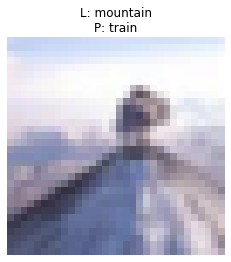

TOP PREDICTED CLASSES:  ['train (0.37)', 'road (0.18)', 'spider (0.17)']
PROPAGATED TREE:
root (1.00)
├── aquatic_mammals (0.03)
│   ├── beaver (0.00)
│   ├── dolphin (0.00)
│   ├── otter (0.00)
│   ├── seal (0.02)
│   └── whale (0.00)
├── fish (0.00)
│   ├── aquarium_fish (0.00)
│   ├── flatfish (0.00)
│   ├── ray (0.00)
│   ├── shark (0.00)
│   └── trout (0.00)
├── flowers (0.00)
│   ├── orchid (0.00)
│   ├── poppy (0.00)
│   ├── rose (0.00)
│   ├── sunflower (0.00)
│   └── tulip (0.00)
├── food_containers (0.00)
│   ├── bottle (0.00)
│   ├── bowl (0.00)
│   ├── can (0.00)
│   ├── cup (0.00)
│   └── plate (0.00)
├── fruit_and_vegetables (0.00)
│   ├── apple (0.00)
│   ├── mushroom (0.00)
│   ├── orange (0.00)
│   ├── pear (0.00)
│   └── sweet_pepper (0.00)
├── household_electrical_devices (0.00)
│   ├── clock (0.00)
│   ├── keyboard (0.00)
│   ├── lamp (0.00)
│   ├── telephone (0.00)
│   └── television (0.00)
├── household_furniture (0.01)
│   ├── bed (0.00)
│   ├── chair (0.00)
│   

In [10]:
# An example hierarchy propagation
index = 0

print('CIFAR-100 IMAGE')
image = test_dataset[index][0].permute(1, 2, 0)
plt.imshow(cifar_util.unnorm_cifar_image(image))
plt.axis('off')
plt.title(f'L: {cifar_metadata.CLASS_LABELS[labels[index]]}\nP: {cifar_metadata.CLASS_LABELS[predictions[index]]}')
plt.show()

top_predictions = np.argsort(outputs[index])[-3:]
print('TOP PREDICTED CLASSES: ', [f'{cifar_metadata.CLASS_LABELS[i]} ({outputs[index][i]:.2f})' for i in top_predictions][::-1])

print('PROPAGATED TREE:')
print(cifar.show(trees[0]))

### Analysis of model abstraction alignment

In [11]:
# Numerical statistics about abstraction alignment
def print_stats(level_stats):
    string = ''
    for level, value in enumerate(level_stats):
        string += f'Level {level} = {value:.2f} '
    return string

level_nodes = {}
for level in range(tree.depth() + 1):
    nodes = tree.filter_nodes(lambda x: tree.depth(x) == level)
    level_nodes[level] = [node.identifier for node in nodes]

mean_probabilities = []
entropies = []
for tree in trees:
    tree_mean_probability = []
    tree_entropy = []
    for level, node_ids in level_nodes.items():
        values = [tree.get_node(node_id).data for node_id in node_ids]
        tree_mean_probability.append(np.mean(values))
        tree_entropy.append(stats.entropy(values))
    mean_probabilities.append(tree_mean_probability)
    entropies.append(tree_entropy)
mean_probabilities = np.vstack(mean_probabilities)
entropies = np.vstack(entropies)

print(f'Mean entropy at each level of abstraction:\t{print_stats(entropies.mean(axis=0))}')

Mean entropy at each level of abstraction:	Level 0 = 0.00 Level 1 = 0.43 Level 2 = 0.71 


#### Examples of different behavior types

In [12]:
def show_examples(indicies, num_examples):
    if len(indicies) > 0:
        example_inds = np.random.choice(indicies, num_examples)
        plot_images(example_inds)
        plt.show()
        print(cifar.show(trees[example_inds[0]]))

def plot_images(indicies):
    fig, ax = plt.subplots(nrows=1, ncols=len(indicies))
    if type(ax) != list:
        ax = [ax]
    for i, index in enumerate(indicies):
        ax[i].imshow(cifar_util.unnorm_cifar_image(test_dataset[index][0].permute(1, 2, 0)))
        ax[i].axis('off')
    return fig

90 images where the model is fully confident in one output.


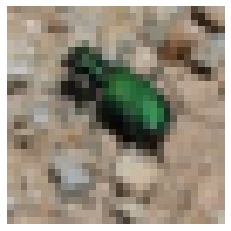

root (1.00)
├── aquatic_mammals (0.00)
│   ├── beaver (0.00)
│   ├── dolphin (0.00)
│   ├── otter (0.00)
│   ├── seal (0.00)
│   └── whale (0.00)
├── fish (0.00)
│   ├── aquarium_fish (0.00)
│   ├── flatfish (0.00)
│   ├── ray (0.00)
│   ├── shark (0.00)
│   └── trout (0.00)
├── flowers (0.00)
│   ├── orchid (0.00)
│   ├── poppy (0.00)
│   ├── rose (0.00)
│   ├── sunflower (0.00)
│   └── tulip (0.00)
├── food_containers (0.00)
│   ├── bottle (0.00)
│   ├── bowl (0.00)
│   ├── can (0.00)
│   ├── cup (0.00)
│   └── plate (0.00)
├── fruit_and_vegetables (0.00)
│   ├── apple (0.00)
│   ├── mushroom (0.00)
│   ├── orange (0.00)
│   ├── pear (0.00)
│   └── sweet_pepper (0.00)
├── household_electrical_devices (0.00)
│   ├── clock (0.00)
│   ├── keyboard (0.00)
│   ├── lamp (0.00)
│   ├── telephone (0.00)
│   └── television (0.00)
├── household_furniture (0.00)
│   ├── bed (0.00)
│   ├── chair (0.00)
│   ├── couch (0.00)
│   ├── table (0.00)
│   └── wardrobe (0.00)
├── insects (1.00)
│   ├── b

In [13]:
# Fully confident in an output class
fully_confident = [i for i, entropy in enumerate(entropies) if entropy[-1] < 0.0001]
print(f'{len(fully_confident)} images where the model is fully confident in one output.')
show_examples(fully_confident, 1)

310 images where the model is fully confident in a superclass.


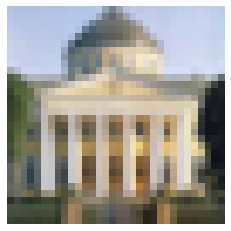

root (1.00)
├── aquatic_mammals (0.00)
│   ├── beaver (0.00)
│   ├── dolphin (0.00)
│   ├── otter (0.00)
│   ├── seal (0.00)
│   └── whale (0.00)
├── fish (0.00)
│   ├── aquarium_fish (0.00)
│   ├── flatfish (0.00)
│   ├── ray (0.00)
│   ├── shark (0.00)
│   └── trout (0.00)
├── flowers (0.00)
│   ├── orchid (0.00)
│   ├── poppy (0.00)
│   ├── rose (0.00)
│   ├── sunflower (0.00)
│   └── tulip (0.00)
├── food_containers (0.00)
│   ├── bottle (0.00)
│   ├── bowl (0.00)
│   ├── can (0.00)
│   ├── cup (0.00)
│   └── plate (0.00)
├── fruit_and_vegetables (0.00)
│   ├── apple (0.00)
│   ├── mushroom (0.00)
│   ├── orange (0.00)
│   ├── pear (0.00)
│   └── sweet_pepper (0.00)
├── household_electrical_devices (0.00)
│   ├── clock (0.00)
│   ├── keyboard (0.00)
│   ├── lamp (0.00)
│   ├── telephone (0.00)
│   └── television (0.00)
├── household_furniture (0.00)
│   ├── bed (0.00)
│   ├── chair (0.00)
│   ├── couch (0.00)
│   ├── table (0.00)
│   └── wardrobe (0.00)
├── insects (0.00)
│   ├── b

In [14]:
# Fully confident at the superclass level
superclass_confident = [i for i, entropy in enumerate(entropies) if entropy[1] < 0.0001]
print(f'{len(superclass_confident)} images where the model is fully confident in a superclass.')
show_examples(superclass_confident, 1)

1151 images where the model is split between two superclass.


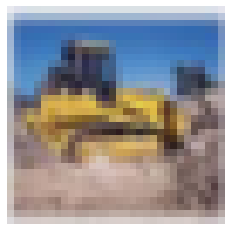

root (1.00)
├── aquatic_mammals (0.00)
│   ├── beaver (0.00)
│   ├── dolphin (0.00)
│   ├── otter (0.00)
│   ├── seal (0.00)
│   └── whale (0.00)
├── fish (0.00)
│   ├── aquarium_fish (0.00)
│   ├── flatfish (0.00)
│   ├── ray (0.00)
│   ├── shark (0.00)
│   └── trout (0.00)
├── flowers (0.00)
│   ├── orchid (0.00)
│   ├── poppy (0.00)
│   ├── rose (0.00)
│   ├── sunflower (0.00)
│   └── tulip (0.00)
├── food_containers (0.00)
│   ├── bottle (0.00)
│   ├── bowl (0.00)
│   ├── can (0.00)
│   ├── cup (0.00)
│   └── plate (0.00)
├── fruit_and_vegetables (0.00)
│   ├── apple (0.00)
│   ├── mushroom (0.00)
│   ├── orange (0.00)
│   ├── pear (0.00)
│   └── sweet_pepper (0.00)
├── household_electrical_devices (0.00)
│   ├── clock (0.00)
│   ├── keyboard (0.00)
│   ├── lamp (0.00)
│   ├── telephone (0.00)
│   └── television (0.00)
├── household_furniture (0.00)
│   ├── bed (0.00)
│   ├── chair (0.00)
│   ├── couch (0.00)
│   ├── table (0.00)
│   └── wardrobe (0.00)
├── insects (0.00)
│   ├── b

In [15]:
# Confidence in two subtrees
two_subtrees = []
superclass_nodes = list(tree.filter_nodes(lambda x: tree.depth(x) == 1))
for i, tree in enumerate(trees):
    values = [tree.get_node(node.identifier).data for node in superclass_nodes]
    if len([1 for value in values if value > 0.0001]) == 2:
        two_subtrees.append(i)
    

print(f'{len(two_subtrees)} images where the model is split between two superclass.')
show_examples(two_subtrees, 1)

#### Examples of common confusions

In [16]:
all_nodes = tree.nodes
node_pairs = {combo: 0 for combo in combinations(all_nodes.keys(), 2) if 'root' not in combo}
for tree in tqdm(trees):
    for node_a_id, node_b_id in node_pairs:
        node_a = tree.get_node(node_a_id)
        node_b = tree.get_node(node_b_id)
        if node_a.data < 0.01 or node_b.data < 0.01:
            continue
        value = stats.entropy([node_a.data, node_b.data])
        node_pairs[(node_a.identifier, node_b.identifier)] += value

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:09<00:00, 20.43it/s]


In [21]:
# Highest overall confusion
sorted_pairs = [k for k, v in sorted(node_pairs.items(), key=lambda item: item[1], reverse=True)]
print('HIGHEST OVERALL CONFUSION:')
for i in range(5):
    print(f'{sorted_pairs[i]} --- {node_pairs[sorted_pairs[i]]:.2f}')

HIGHEST OVERALL CONFUSION:
('non-insect_invertebrates', 'reptiles') --- 384.33
('household_electrical_devices', 'lamp') --- 383.42
('large_carnivores', 'bear') --- 375.46
('aquatic_mammals', 'seal') --- 373.78
('medium_mammals', 'small_mammals') --- 369.42


In [23]:
# Confusion between superclass nodes
superclass_pairs = [(a, b) for a, b in sorted_pairs if tree.depth(a) == 1 and tree.depth(b) == 1]
print('HIGHEST SUPERCLASS CONFUSION:')
for i in range(5):
    print(f'{superclass_pairs[i]} --- {node_pairs[superclass_pairs[i]]:.2f}')

HIGHEST SUPERCLASS CONFUSION:
('non-insect_invertebrates', 'reptiles') --- 384.33
('medium_mammals', 'small_mammals') --- 369.42
('large_carnivores', 'large_omnivores_and_herbivores') --- 361.98
('large_carnivores', 'medium_mammals') --- 353.98
('aquatic_mammals', 'small_mammals') --- 325.53


In [26]:
# Confusion between nodes in different subtrees
unrelated_pairs = []
for a, b in sorted_pairs:
    if tree.is_ancestor(a, b) or tree.is_ancestor(b, a):
        continue
    a_siblings = set([n.identifier for n in tree.siblings(a)])
    if b in a_siblings:
        continue
    b_siblings = set([n.identifier for n in tree.siblings(b)])
    if a in b_siblings:
        continue
    unrelated_pairs.append((a,b))
    
print('HIGHEST CONFUSION BETWEEN UNRELATED NODES:')
for i in range(5):
    print(f'{unrelated_pairs[i]} --- {node_pairs[unrelated_pairs[i]]:.2f}')

HIGHEST CONFUSION BETWEEN UNRELATED NODES:
('large_omnivores_and_herbivores', 'bear') --- 191.97
('aquatic_mammals', 'bear') --- 177.28
('aquatic_mammals', 'shrew') --- 175.59
('small_mammals', 'seal') --- 173.96
('small_mammals', 'otter') --- 173.04
